# Aggregate RPE Signalling

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from util.gmm import EXAMPLE
from util.expectiles import expectile

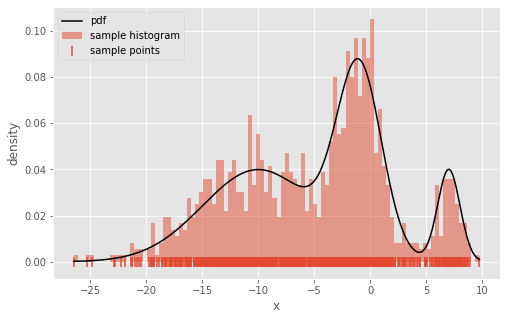

In [8]:
SAMPLE, *_ = EXAMPLE(1000, figsize=(8, 5))
NEURAL_TAUS = np.array([0.00336147, 0.02108205, 0.04991431, 0.24368197, 0.42196866,
                        0.22353116, 0.47702077, 0.29611582, 0.36181693, 0.442517  ,
                        0.51354238, 0.29136287, 0.24596278, 0.33895973, 0.41090296,
                        0.54775816, 0.2238155 , 0.98442344, 0.53931528, 0.41450776,
                        0.56729758, 0.58246691, 0.68976626, 0.34638865, 0.55480031,
                        0.5570765 , 0.66221661, 0.71219295, 0.65433601, 0.79852221,
                        0.75769016, 0.70370061, 0.7311324 , 0.63879298, 0.66074851,
                        0.68294063, 0.75187872, 0.80620104, 0.67485657, 0.95602078])

## Signalling RPEs

The hypothesis goes that these 'neurons' are responsible for calculating and signalling RPEs. The response is determined by the positive or negative rate and the reversal point. I expect that the average response will matter for downstream learning (maybe this is not the case, and downstream neurons tune in to signals of a particular asymmety for some reason...?). If so, it will be a weighted average according to the asymmetry distribution. Let's investigate how this signal varies in response to the magnitude of a reward!

In [2]:
def rpe_signal_spectrum(taus, sample, base_learn_rate=0.01):
    taus = np.array(taus)
    epss = np.array(expectile(sample, taus))

    learn_rate_factors = np.sqrt(taus/(1-taus))
    # note: here I am including assumptions about how
    # the learning rates are distributed about a base
    # rate. could use some actual neural data...?
    neg_learn_rates = base_learn_rate / learn_rate_factors
    pos_learn_rates = base_learn_rate * learn_rate_factors
    
    rewards = np.linspace(np.min(sample), np.max(sample), 100)
    responses = np.zeros((100, taus.size))
    for i, x in enumerate(rewards):
        # decide learn rates for each neuron (based on whether
        # signal is above or below expectation)
        learn_rates = neg_learn_rates.copy()
        pos_err = np.where(x > epss)
        learn_rates[pos_err] = pos_learn_rates[pos_err]
        # these determine the response
        responses[i] = learn_rates * (x - epss)
        
    means_response = base_learn_rate * (rewards - np.mean(sample))
    
    plt.fill_between(rewards, responses.max(axis=1), responses.min(axis=1),
            color="gray", alpha=0.5, label="individual neuron responses")
    for j in range(epss.size):
        plt.plot(rewards, responses[:, j], alpha=0.5, color="gray")
    plt.plot(rewards, np.mean(responses, axis=1), linewidth=3,
             label="mean response of all neurons")
    plt.plot(rewards, means_response, linewidth=3,
             label=r"response of $\tau=0.5$ neuron")
    plt.xlabel("reward")
    plt.ylabel("response (reward prediction error)")
    plt.legend()

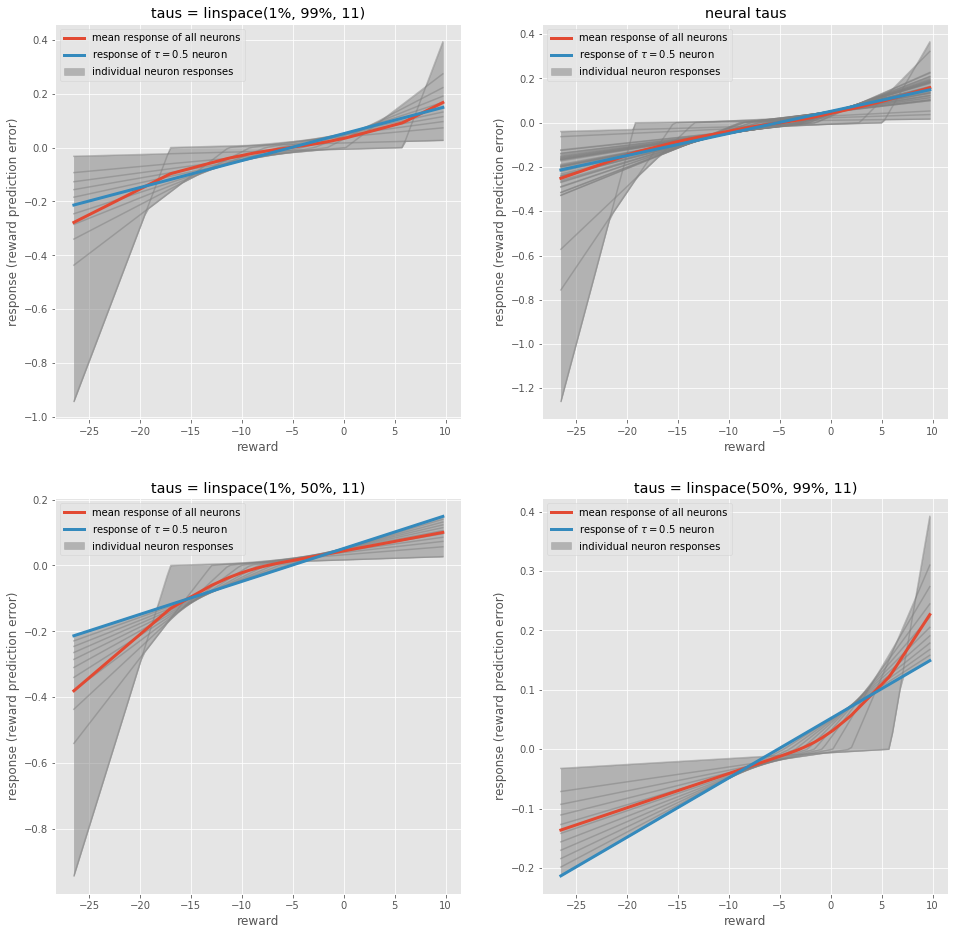

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))

ax1.set_title("taus = linspace(1%, 99%, 11)")
plt.sca(ax1)
rpe_signal_spectrum(np.linspace(0.01, 0.99, 11), SAMPLE)

ax2.set_title("neural taus")
plt.sca(ax2)
rpe_signal_spectrum(NEURAL_TAUS, SAMPLE)

ax3.set_title("taus = linspace(1%, 50%, 11)")
plt.sca(ax3)
rpe_signal_spectrum(np.linspace(0.01, 0.5, 11), SAMPLE)

ax4.set_title("taus = linspace(50%, 99%, 11)")
plt.sca(ax4)
rpe_signal_spectrum(np.linspace(0.5, 0.99, 11), SAMPLE)

plt.show()